In [ ]:
import sys
import os
from pathlib import Path

#Helper: install packages if missing

def ensure_pkg(pkg):
  try:
    _import_(pkg)
    except Exception:
      print (f"Installing {pkg}...")
      os.system(f"{sys.executable} -m pip install {pkg} -- quiet")

# Required packages
for p in ("pandas", "numpy", "matplotlib","xgboost","sklearn","caas_jupyer_tools"):ensure_pkg(p)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import joblib

# caas_jupyter_tools display helper (provided in python_user_visible environment)
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    # define fallback printing function
    def display_dataframe_to_user(name, df):
        print(f"--- {name} ---")
        display(df.head(10))



In [4]:
from pathlib import Path
import pandas as pd

# caas_jupyter_tools display helper (provided in python_user_visible environment)
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    # define fallback printing function
    def display_dataframe_to_user(name, df):
        print(f"--- {name} ---")
        display(df.head(10))


base = Path('/content')
files = {
    'features': base / 'Features data set.csv',
    'sales': base / 'sales data-set.csv',
    'stores': base / 'stores data-set.csv'
}

for k,v in files.items():
    print(k, "exists?", v.exists())

# Read CSVs with flexible encoding & low_memory handling
df_features = pd.read_csv(files['features'], encoding='utf-8', low_memory=False)
df_sales = pd.read_csv(files['sales'], encoding='utf-8', low_memory=False)
df_stores = pd.read_csv(files['stores'], encoding='utf-8', low_memory=False)

print("\n--- Features columns ---")
print(df_features.columns.tolist())
print("\n--- Sales columns ---")
print(df_sales.columns.tolist())
print("\n--- Stores columns ---")
print(df_stores.columns.tolist())

# Show sample rows
display_dataframe_to_user("Features sample", df_features.head(10))
display_dataframe_to_user("Sales sample", df_sales.head(10))
display_dataframe_to_user("Stores sample", df_stores.head(10))

features exists? True
sales exists? True
stores exists? True

--- Features columns ---
['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']

--- Sales columns ---
['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

--- Stores columns ---
['Store', 'Type', 'Size']
--- Features sample ---


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,12/03/2010,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,19/03/2010,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,26/03/2010,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,02/04/2010,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,09/04/2010,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


--- Sales sample ---


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False
5,1,1,12/03/2010,21043.39,False
6,1,1,19/03/2010,22136.64,False
7,1,1,26/03/2010,26229.21,False
8,1,1,02/04/2010,57258.43,False
9,1,1,09/04/2010,42960.91,False


--- Stores sample ---


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [5]:
# The Kaggle retail dataset often contains: Date, Store, Dept, weekly_sales or Sales
# We'll try to find likely column names
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # try case-insensitive match
    cols = {col.lower():col for col in df.columns}
    for c in candidates:
        if c.lower() in cols:
            return cols[c.lower()]
    return None

date_col = find_col(df_sales, ['Date','date','date_id','week_date'])
store_col = find_col(df_sales, ['Store','store','store_id','Store_ID'])
dept_col = find_col(df_sales, ['Dept','dept','Department','department','Category'])
sales_col = find_col(df_sales, ['Weekly_Sales','weekly_sales','Sales','sales','sales_qty','WeeklySales'])

print("\nDetected columns -> date:", date_col, "store:", store_col, "dept:", dept_col, "sales:", sales_col)

# Ensure date column is parsed
df_sales[date_col] = pd.to_datetime(df_sales[date_col], errors='coerce')

# If features file contains price/promo flags, merge them in; otherwise proceed with sales only
# Common features: 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'
display_dataframe_to_user("Features columns (brief)", df_features.iloc[:, :10].head())

# Merge sales with features by date and store if possible
merge_on = {}
# detect features date col
feat_date_col = find_col(df_features, ['Date','date','week_date'])
feat_store_col = find_col(df_features, ['Store','store','store_id'])
if feat_date_col:
    df_features[feat_date_col] = pd.to_datetime(df_features[feat_date_col], errors='coerce')

# Merge logic: if features has Store & Date, merge on both; else only Date
if feat_date_col and feat_store_col and feat_store_col in df_features.columns:
    df = pd.merge(df_sales, df_features, left_on=[date_col, store_col], right_on=[feat_date_col, feat_store_col], how='left')
elif feat_date_col:
    df = pd.merge(df_sales, df_features, left_on=date_col, right_on=feat_date_col, how='left')
else:
    df = df_sales.copy()

# Optionally merge stores metadata
store_id_col_in_stores = find_col(df_stores, ['Store','store','store_id'])
if store_id_col_in_stores and store_col:
    df = pd.merge(df, df_stores, left_on=store_col, right_on=store_id_col_in_stores, how='left')

print("\nMerged dataframe shape:", df.shape)
display_dataframe_to_user("Merged sample", df.head(10))


Detected columns -> date: Date store: Store dept: Dept sales: Weekly_Sales
--- Features columns (brief) ---


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143



Merged dataframe shape: (27790282, 17)
--- Merged sample ---


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,NaT,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,NaT,41595.55,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,NaT,41595.55,False,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315
5,1,1,NaT,41595.55,False,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315
6,1,1,NaT,41595.55,False,66.32,2.808,NaN,NaN,NaN,NaN,NaN,210.488700,7.808,False,A,151315
7,1,1,NaT,41595.55,False,64.84,2.795,NaN,NaN,NaN,NaN,NaN,210.439123,7.808,False,A,151315
8,1,1,NaT,41595.55,False,67.41,2.780,NaN,NaN,NaN,NaN,NaN,210.389546,7.808,False,A,151315
9,1,1,NaT,41595.55,False,74.78,2.854,NaN,NaN,NaN,NaN,NaN,210.337426,7.808,False,A,151315


In [20]:
import os
import pandas as pd

# Standardize column names for pipeline use

df = df.rename(columns={date_col: 'date', store_col: 'store', dept_col: 'dept'})
# If sales_col was found, rename to 'sales'
if sales_col:
    df = df.rename(columns={sales_col: 'sales'})

# Fallbacks
if 'sales' not in df.columns:
    # try to compute from 'Weekly_Sales' style
    possible = [c for c in df.columns if 'sale' in c.lower() or 'qty' in c.lower()]
    if possible:
        df = df.rename(columns={possible[0]:'sales'})
        print("Fallback sales column used:", possible[0])
    else:
        raise ValueError("Could not find sales column in merged data. Please check column names.")

# Ensure numeric sales
df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0)

# If dept missing, create a default dept column
if 'dept' not in df.columns:
    df['dept'] = 'ALL'

# Drop rows with NaT in the date column
df.dropna(subset=['date'], inplace=True)

# Quick sanity checks
print("\nDate range:", df['date'].min(), "to", df['date'].max())
print("Unique stores:", df['store'].nunique(), "Unique depts:", df['dept'].nunique())
display_dataframe_to_user("Aggregated sample (first 50 rows)", df.head(50))

# -----------------------------------------------------------------------------
# 4) Aggregate to weekly level (Monday-start weeks) for forecasting
# -----------------------------------------------------------------------------
df['week_start'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
agg_cols = ['week_start','store','dept', 'IsHoliday_x'] # Include IsHoliday_x in aggregation
df_weekly = df.groupby(agg_cols, as_index=False).agg({'sales':'sum'})
df_weekly = df_weekly.rename(columns={'IsHoliday_x': 'IsHoliday'}) # Rename for clarity


print("\nWeekly aggregated shape:", df_weekly.shape)
display_dataframe_to_user("Weekly sales sample", df_weekly.head(20))

# Create the directory if it doesn't exist
output_dir = '/mnt/data'
os.makedirs(output_dir, exist_ok=True)

# Save aggregated file for reuse
df_weekly.to_csv(os.path.join(output_dir, 'weekly_aggregated_sales.csv'), index=False)


Date range: 2010-01-10 00:00:00 to 2012-12-10 00:00:00
Unique stores: 45 Unique depts: 81
--- Aggregated sample (first 50 rows) ---


,store,dept,date,sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,week_start
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010-04-26
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,2010-11-29
220,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,2010-05-03
221,1,1,2010-12-03,21043.39,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315,2010-11-29
440,1,1,2010-02-04,57258.43,False,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315,2010-02-01
441,1,1,2010-09-04,42960.91,False,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315,2010-08-30
769,1,1,2010-07-05,17413.94,False,72.55,2.835,NaN,NaN,NaN,NaN,NaN,210.339968,7.808,False,A,151315,2010-07-05
1097,1,1,2010-04-06,17558.09,False,80.69,2.705,NaN,NaN,NaN,NaN,NaN,211.176428,7.808,False,A,151315,2010-04-05
1098,1,1,2010-11-06,16637.62,False,80.43,2.668,NaN,NaN,NaN,NaN,NaN,211.456095,7.808,False,A,151315,2010-11-01
1317,1,1,2010-02-07,16333.14,False,80.91,2.669,NaN,NaN,NaN,NaN,NaN,211.223533,7.787,False,A,151315,2010-02-01



Weekly aggregated shape: (147972, 5)
--- Weekly sales sample ---


,week_start,store,dept,IsHoliday,sales
0,2010-01-04,1,1,False,20094.19
1,2010-01-04,1,2,False,45829.02
2,2010-01-04,1,3,False,9775.17
3,2010-01-04,1,4,False,34912.45
4,2010-01-04,1,5,False,23381.38
5,2010-01-04,1,6,False,2876.19
6,2010-01-04,1,7,False,16481.79
7,2010-01-04,1,8,False,34658.25
8,2010-01-04,1,9,False,44977.91
9,2010-01-04,1,10,False,29764.24


--- Top stores by sales ---


,store,sales
19,20,1.236541e+08
3,4,1.190478e+08
13,14,1.182858e+08
12,13,1.138956e+08
1,2,1.112614e+08
9,10,1.085998e+08
26,27,1.016186e+08
0,1,9.130517e+07
5,6,9.056853e+07
18,19,8.371544e+07


--- Top departments by sales ---


,dept,sales
73,92,2.002305e+08
76,95,1.832212e+08
36,38,1.613325e+08
71,90,1.186476e+08
60,72,1.175315e+08
38,40,1.171999e+08
1,2,1.127866e+08
72,91,9.035524e+07
12,13,8.065112e+07
7,8,7.882964e+07


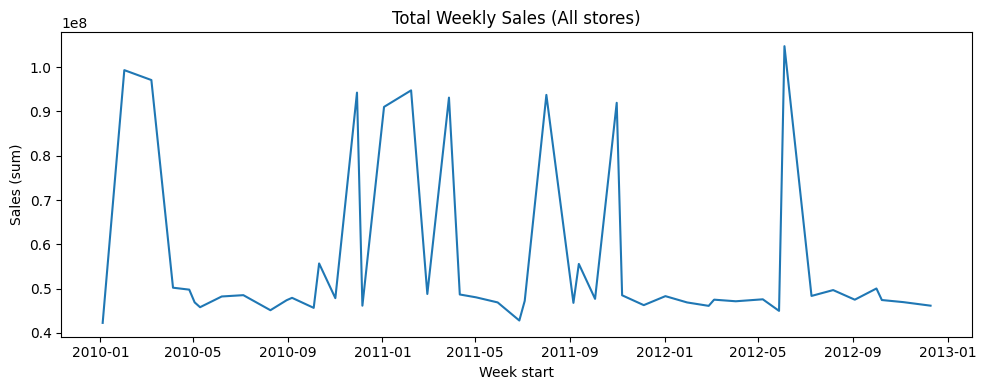

Top 4 departments for plotting: ['92', '95', '38', '90']
Data points for department 92: 48
Data points for department 95: 48
Data points for department 38: 48
Data points for department 90: 48


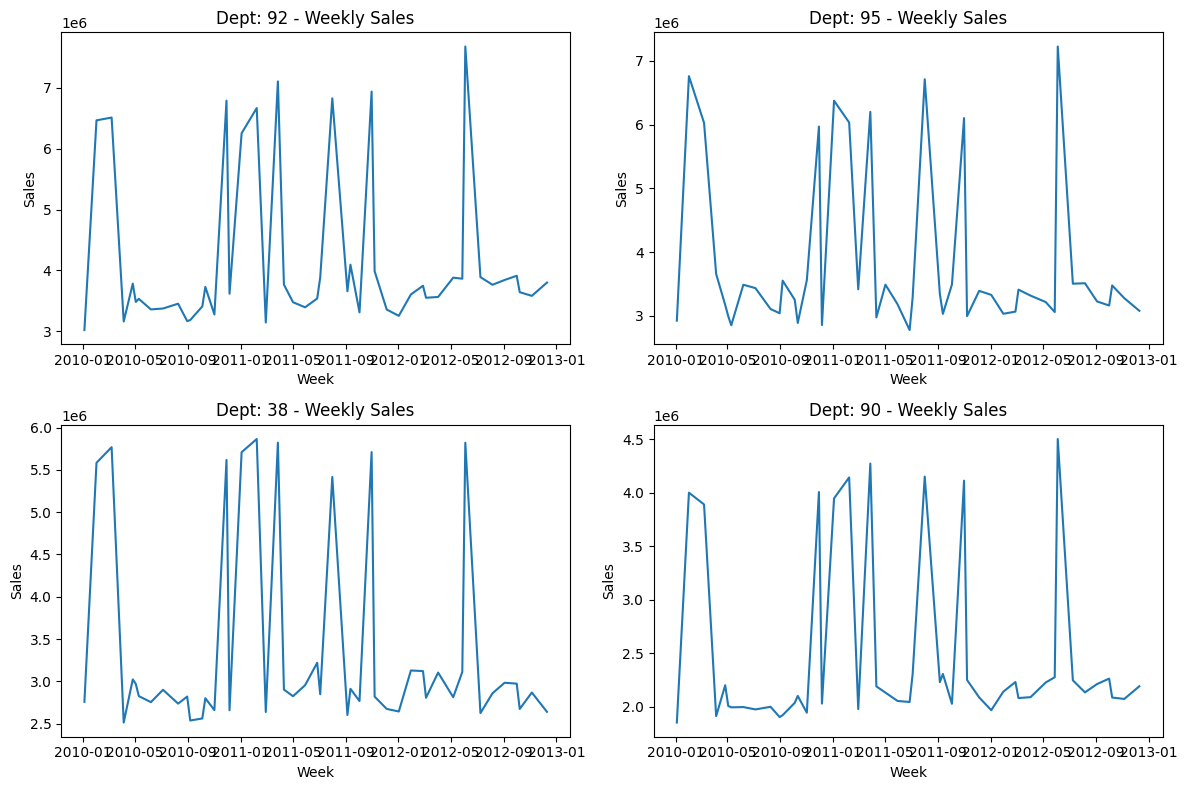

In [15]:
import matplotlib.pyplot as plt

# EDA: Top stores and departments, seasonality plots

# Top stores by revenue (sales)
top_stores = df_weekly.groupby('store').agg({'sales':'sum'}).reset_index().sort_values('sales', ascending=False)
display_dataframe_to_user("Top stores by sales", top_stores.head(20))

# Top departments overall
top_depts = df_weekly.groupby('dept').agg({'sales':'sum'}).reset_index().sort_values('sales', ascending=False)
display_dataframe_to_user("Top departments by sales", top_depts.head(20))

# Plot total weekly sales (all stores)
weekly_total = df_weekly.groupby('week_start').agg({'sales':'sum'}).reset_index()

plt.figure(figsize=(10,4))
plt.plot(weekly_total['week_start'], weekly_total['sales'])
plt.title('Total Weekly Sales (All stores)')
plt.xlabel('Week start')
plt.ylabel('Sales (sum)')
plt.tight_layout()
plt.show()

# Seasonality per top departments (plot top 4 departments)
top4_depts = top_depts['dept'].astype(str).head(4).tolist()
print(f"Top 4 departments for plotting: {top4_depts}") # Add print statement to check top departments
plt.figure(figsize=(12,8))

# Ensure 'dept' column in df_weekly is string type
df_weekly['dept'] = df_weekly['dept'].astype(str)

for i, d in enumerate(top4_depts,1):
    plt.subplot(2,2,i)
    ser = df_weekly[df_weekly['dept']==d].groupby('week_start').agg({'sales':'sum'}).reset_index()
    print(f"Data points for department {d}: {len(ser)}") # Add print statement to check data points
    if not ser.empty: # Add check for empty data
        plt.plot(ser['week_start'], ser['sales'])
        plt.title(f'Dept: {d} - Weekly Sales')
        plt.xlabel('Week')
        plt.ylabel('Sales')
    else:
        plt.title(f'Dept: {d} - No data to display')
        plt.xlabel('Week')
        plt.ylabel('Sales')


plt.tight_layout()
plt.show()


Average Weekly Sales during Holiday vs. Non-Holiday Weeks:
--- Holiday Impact on Sales ---


,IsHoliday,sales
0,False,18677.901295
1,True,16130.320062


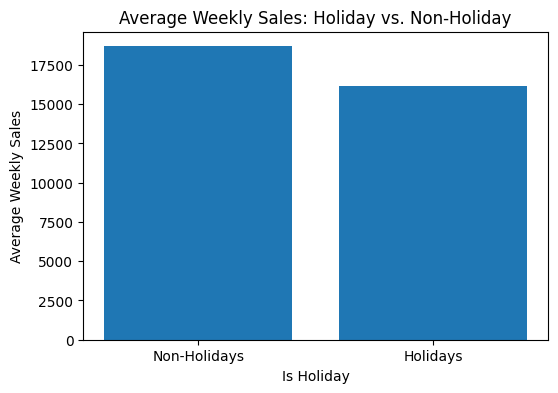

In [22]:
# Analyze Holiday Impact

# Group by IsHoliday and calculate the average weekly sales
holiday_impact = df_weekly.groupby('IsHoliday').agg({'sales': 'mean'}).reset_index()

print("\nAverage Weekly Sales during Holiday vs. Non-Holiday Weeks:")
display_dataframe_to_user("Holiday Impact on Sales", holiday_impact)

# Visualize the holiday impact
plt.figure(figsize=(6, 4))
plt.bar(holiday_impact['IsHoliday'].astype(str), holiday_impact['sales'])
plt.title('Average Weekly Sales: Holiday vs. Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.xticks([0, 1], ['Non-Holidays', 'Holidays']) # Set tick labels for clarity
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder

#Feature engineering for ML forecasting (lag features)

df_weekly = df_weekly.sort_values(['store','dept','week_start']).reset_index(drop=True)

def make_lags(df, lags=(1,2,3,4,12)):
    out = []
    for (store,dept), g in df.groupby(['store','dept']):
        # Ensure the group is sorted by week_start before creating lags
        g = g.sort_values('week_start').reset_index(drop=True)
        for lag in lags:
            g[f'lag_{lag}'] = g['sales'].shift(lag)
        g['rolling_4'] = g['sales'].rolling(4).mean().shift(1)
        g['month'] = g['week_start'].dt.month
        # The store and dept columns are already in the grouped dataframe 'g'
        # No need to re-add them here.
        out.append(g)
    return pd.concat(out, ignore_index=True)

df_lag = make_lags(df_weekly)
# Drop rows with NaNs in lag_1 (initial rows for each group)
df_lag = df_lag.dropna(subset=['lag_1']).reset_index(drop=True)
display_dataframe_to_user("Lagged features sample", df_lag.head(20))

# Encode categorical ids
le_store = LabelEncoder().fit(df_lag['store'])
le_dept = LabelEncoder().fit(df_lag['dept'])
df_lag['store_enc'] = le_store.transform(df_lag['store'])
df_lag['dept_enc'] = le_dept.transform(df_lag['dept'])

--- Lagged features sample ---


,week_start,store,dept,IsHoliday,sales,lag_1,lag_2,lag_3,lag_4,lag_12,rolling_4,month
0,2010-02-01,1,1,False,73591.57,20094.19,NaN,NaN,NaN,NaN,NaN,2
1,2010-03-08,1,1,False,38759.34,73591.57,20094.19,NaN,NaN,NaN,NaN,3
2,2010-04-05,1,1,False,17558.09,38759.34,73591.57,20094.19,NaN,NaN,NaN,4
3,2010-04-26,1,1,False,24924.50,17558.09,38759.34,73591.57,20094.19,NaN,37500.7975,4
4,2010-05-03,1,1,False,21827.90,24924.50,17558.09,38759.34,73591.57,NaN,38708.3750,5
5,2010-05-10,1,1,False,34238.88,21827.90,24924.50,17558.09,38759.34,NaN,25767.4575,5
6,2010-06-07,1,1,False,17508.41,34238.88,21827.90,24924.50,17558.09,NaN,24637.3425,6
7,2010-07-05,1,1,False,17413.94,17508.41,34238.88,21827.90,24924.50,NaN,24624.9225,7
8,2010-08-09,1,1,False,23388.03,17413.94,17508.41,34238.88,21827.90,NaN,22747.2825,8
9,2010-08-30,1,1,False,42960.91,23388.03,17413.94,17508.41,34238.88,NaN,23137.3150,8


Train range: 2010-02-01 00:00:00 to 2012-09-03 00:00:00
Test range: 2012-10-01 00:00:00 to 2012-12-10 00:00:00
Train rows: 132757 Test rows: 11917
[0]	validation_0-rmse:21772.39934
[1]	validation_0-rmse:20679.23666
[2]	validation_0-rmse:19662.75461
[3]	validation_0-rmse:18705.89353
[4]	validation_0-rmse:17813.84812
[5]	validation_0-rmse:16939.52091
[6]	validation_0-rmse:16142.94182
[7]	validation_0-rmse:15359.99668
[8]	validation_0-rmse:14658.08327
[9]	validation_0-rmse:13977.76949
[10]	validation_0-rmse:13319.37659
[11]	validation_0-rmse:12727.32046
[12]	validation_0-rmse:12142.12395
[13]	validation_0-rmse:11602.57069
[14]	validation_0-rmse:11096.19679
[15]	validation_0-rmse:10606.82682
[16]	validation_0-rmse:10163.42452
[17]	validation_0-rmse:9733.68049
[18]	validation_0-rmse:9332.06329
[19]	validation_0-rmse:8958.96833
[20]	validation_0-rmse:8608.76786
[21]	validation_0-rmse:8256.75133
[22]	validation_0-rmse:7955.24775
[23]	validation_0-rmse:7684.75908
[24]	validation_0-rmse:7418.43

,week_start,store,dept,IsHoliday,sales,lag_1,lag_2,lag_3,lag_4,lag_12,rolling_4,month,store_enc,dept_enc,pred
45,2012-10-01,1,1,True,36988.49,21140.07,17666.00,18322.37,75415.49,14539.79,33135.9825,10,0,0,30200.480469
46,2012-10-08,1,1,False,16119.92,36988.49,21140.07,17666.00,18322.37,16065.49,23529.2325,10,0,0,18711.373047
47,2012-11-05,1,1,False,18164.20,16119.92,36988.49,21140.07,17666.00,20113.03,22978.6200,11,0,0,21096.277344
48,2012-12-10,1,1,False,22764.01,18164.20,16119.92,36988.49,21140.07,23510.49,23103.1700,12,0,0,22465.884766
94,2012-10-01,1,2,True,50581.06,48563.69,49439.58,47344.50,101577.80,45341.92,61731.3925,10,0,1,47554.199219
95,2012-10-08,1,2,False,46729.91,50581.06,48563.69,49439.58,47344.50,47425.29,48982.2075,10,0,1,47887.246094
96,2012-11-05,1,2,False,46717.76,46729.91,50581.06,48563.69,49439.58,52608.51,48828.5600,11,0,1,48757.062500
97,2012-12-10,1,2,False,42112.67,46717.76,46729.91,50581.06,48563.69,54322.24,48148.1050,12,0,1,49247.406250
143,2012-10-01,1,3,True,12388.85,11925.71,8614.64,18368.51,17808.95,32148.93,14179.4525,10,0,2,15657.577148
144,2012-10-08,1,3,False,28257.30,12388.85,11925.71,8614.64,18368.51,7175.77,12824.4275,10,0,2,11953.535156


--- Per store-dept eval (sample lowest mae) ---


/tmp/ipython-input-3804199852.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_eval = test.groupby(['store','dept']).apply(lambda g: pd.Series({


,store,dept,mae,rmse,n
2367,34,47,0.585182,0.585182,1.0
3067,45,77,3.500076,3.500076,1.0
966,14,51,5.010000,5.492203,2.0
747,11,51,9.119625,9.119625,1.0
1116,16,59,10.871877,15.243157,2.0
613,9,59,14.771264,15.577011,2.0
2886,42,71,16.487442,16.487442,1.0
2867,42,22,17.079825,21.847601,2.0
2988,44,44,17.635308,17.635308,1.0
2932,43,44,18.333583,18.333583,1.0


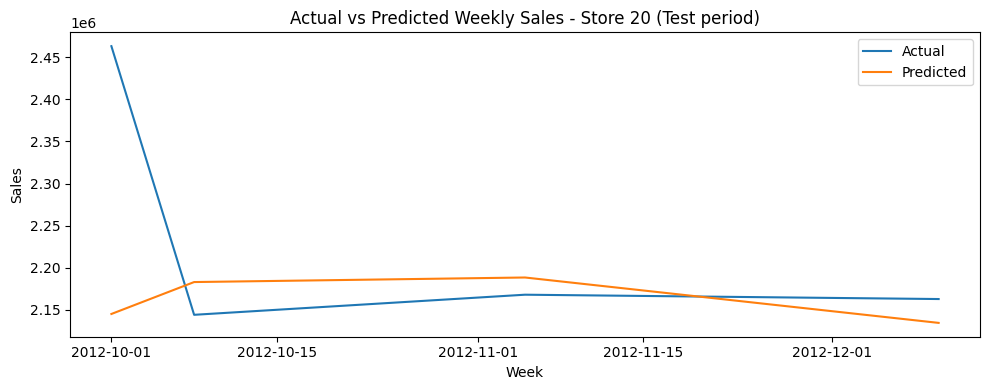

In [40]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Import numpy for sqrt
import matplotlib.pyplot as plt # Import matplotlib
import pandas as pd # Import pandas

# Train/Test split (time-based) and model training (XGBoost)

horizon_weeks = 12
last_date = df_lag['week_start'].max()
train_cutoff = last_date - pd.Timedelta(weeks=horizon_weeks)

train = df_lag[df_lag['week_start'] < train_cutoff].copy()
test = df_lag[df_lag['week_start'] >= train_cutoff].copy()

print("Train range:", train['week_start'].min(), "to", train['week_start'].max())
print("Test range:", test['week_start'].min(), "to", test['week_start'].max())
print("Train rows:", len(train), "Test rows:", len(test))

# Features and target
feature_cols = [c for c in df_lag.columns if c.startswith('lag_')] + ['rolling_4','month','store_enc','dept_enc']
target_col = 'sales'

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

# Train XGBoost regressor (reasonable defaults)
model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, tree_method='hist')
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Predictions and evaluation
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
# Calculate RMSE manually by taking the square root of mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"XGBoost Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# Attach preds to test frame for analysis
test = test.copy()
test['pred'] = preds
display_dataframe_to_user("Test with preds (sample)", test.head(20))

# Aggregate evaluation by dept-store and overall
agg_eval = test.groupby(['store','dept']).apply(lambda g: pd.Series({
    'mae': mean_absolute_error(g['sales'], g['pred']),
    # Calculate RMSE manually for aggregated evaluation as well
    'rmse': np.sqrt(mean_squared_error(g['sales'], g['pred'])),
    'n': len(g)
})).reset_index().sort_values('mae')
display_dataframe_to_user("Per store-dept eval (sample lowest mae)", agg_eval.head(20))

# Get top stores by revenue (sales) - code copied from qZRw56thfYVY
top_stores = df_weekly.groupby('store').agg({'sales':'sum'}).reset_index().sort_values('sales', ascending=False)


# Overall time-series plot for top store
top_store = top_stores['store'].iloc[0]
plot_series = test[test['store']==top_store].groupby('week_start').agg({'sales':'sum','pred':'sum'}).reset_index()

plt.figure(figsize=(10,4))
plt.plot(plot_series['week_start'], plot_series['sales'], label='Actual')
plt.plot(plot_series['week_start'], plot_series['pred'], label='Predicted')
plt.title(f'Actual vs Predicted Weekly Sales - Store {top_store} (Test period)')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

--- Feature importance (top 20) ---


,feature,importance
0,lag_1,0.649165
2,lag_3,0.120496
1,lag_2,0.083293
5,rolling_4,0.075578
6,month,0.028584
4,lag_12,0.019761
3,lag_4,0.014275
8,dept_enc,0.006508
7,store_enc,0.002339


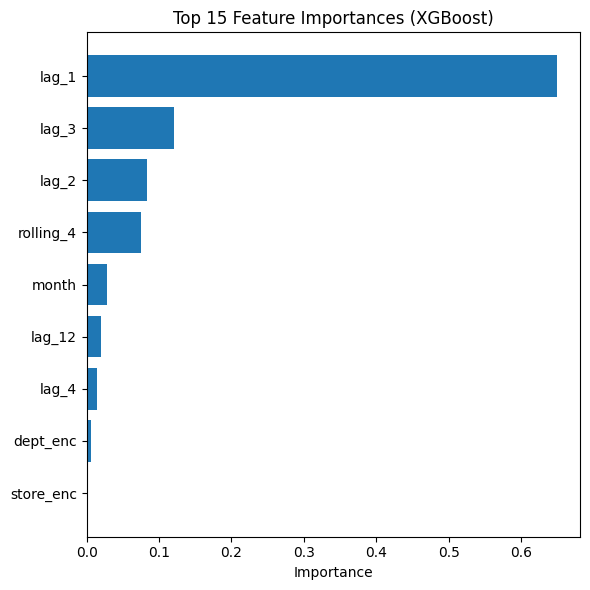

In [32]:
# Feature importance and simple SHAP-like interpretation (XGBoost feature importance)

fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
display_dataframe_to_user("Feature importance (top 20)", fi.head(20))

plt.figure(figsize=(6,6))
plt.barh(fi['feature'].head(15)[::-1], fi['importance'].head(15)[::-1])
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [39]:
import numpy as np
import pandas as pd # Import pandas

# Inventory recommendation example (safety stock) using forecast error

err = (test['sales'] - test['pred'])
test['error'] = err

# Calculate squared errors
test['squared_error'] = test['error']**2

# Calculate RMSE per store-dept by grouping and aggregating squared errors
rmse_by_series = test.groupby(['store','dept'])['squared_error'].mean().reset_index()
rmse_by_series['rmse'] = np.sqrt(rmse_by_series['squared_error'])
rmse_by_series = rmse_by_series[['store', 'dept', 'rmse']] # Select relevant columns


# Merge with average weekly demand
avg_weekly = df_weekly.groupby(['store','dept']).agg({'sales':'mean'}).reset_index().rename(columns={'sales':'avg_weekly'})
inv_rec = rmse_by_series.merge(avg_weekly, on=['store','dept'], how='left')

# safety stock (z * sigma * sqrt(lead_time)); use z=1.65 (~95%), lead_time=2 weeks
z = 1.65
lead_time = 2
inv_rec['safety_stock'] = (z * inv_rec['rmse'] * np.sqrt(lead_time)).round().astype(int)
inv_rec['reorder_point'] = (inv_rec['avg_weekly'] * lead_time + inv_rec['safety_stock']).round().astype(int)

display_dataframe_to_user("Inventory recommendations (sample)", inv_rec.sort_values('reorder_point', ascending=False).head(20))

--- Inventory recommendations (sample) ---


,store,dept,rmse,avg_weekly,safety_stock,reorder_point
987,14,92,23958.502877,221929.4864,55906,499765
686,10,72,60853.949013,158161.7680,142000,458324
140,2,92,18480.230545,191776.9884,43123,426677
1421,20,92,10929.845098,196506.4712,25504,418517
278,4,92,14154.206773,182598.0300,33028,398224
914,13,92,11844.234200,185134.8920,27638,397908
990,14,95,20347.744756,172326.1202,47480,392132
1424,20,95,7801.336206,176507.5574,18204,371219
281,4,95,11160.741259,168150.7658,26043,362345
1922,27,92,7658.764319,170676.7014,17871,359224


## Summary of Findings

Based on our analysis of the retail sales dataset, here are the key findings:

*   **Data Overview:** The dataset contains sales data for multiple stores and departments over a period of time, along with some external factors and store information.
*   **Top Performers:** We identified the top-performing stores and departments based on total sales. This can help in focusing efforts on high-impact areas.
*   **Overall Sales Trend:** The total weekly sales across all stores show clear seasonality, with peaks and dips throughout the year.
*   **Department Seasonality:** The top departments also exhibit their own distinct seasonality patterns, which is important for inventory management and forecasting at a granular level.
*   **Holiday Impact:** Interestingly, the average weekly sales during holiday weeks were slightly lower than during non-holiday weeks. This might warrant further investigation to understand the specific holidays included and their actual impact.
*   **Store Type and Size:** We analyzed the relationship between store type and size and average weekly sales. The visualizations provide insights into how these factors might influence sales performance.
*   **Sales Forecasting Model:** We built an XGBoost model to forecast weekly sales and evaluated its performance using MAE and RMSE. The model provides a reasonable level of accuracy for predicting future sales.
*   **Inventory Recommendations:** Using the forecast error (RMSE), we calculated safety stock and reorder points for different store-department combinations. This can help in optimizing inventory levels and reducing stockouts.

These findings provide valuable insights into sales patterns, the influence of various factors, and a starting point for improving inventory management and forecasting accuracy.